In [1]:
import pickle
import warnings
from math import sqrt

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

# from utils.metrics import evaluate

In [4]:
resultsDict = {}
predictionsDict = {}

df = pd.read_csv('/home/primedo/hcmus/DA/Datascience_2016-2/data/vietnam/vietnam_[2017-2022]_fix.csv')
df_hn = df[df.Province == 'Hà Nội']
df_hn = df_hn.reset_index(drop=True)
# air_pollution.set_index('date', inplace=True)

split_year = 2022 
df_training = df_hn.loc[df_hn.Year < split_year]
df_test = df_hn.loc[df_hn.Year >= split_year]

print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

14608 days of training data 
 1448 days of testing data 


In [5]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Temperature))):
    temp_train = df[:len(df_training)+t]
    model = SARIMAX(temp_train.Temperature, order=(
        1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
# resultsDict['SARIMAX'] = evaluate(df_test.pollution_today, yhat.values)
# predictionsDict['SARIMAX'] = yhat.values

100%|██████████| 1448/1448 [04:05<00:00,  5.89it/s]


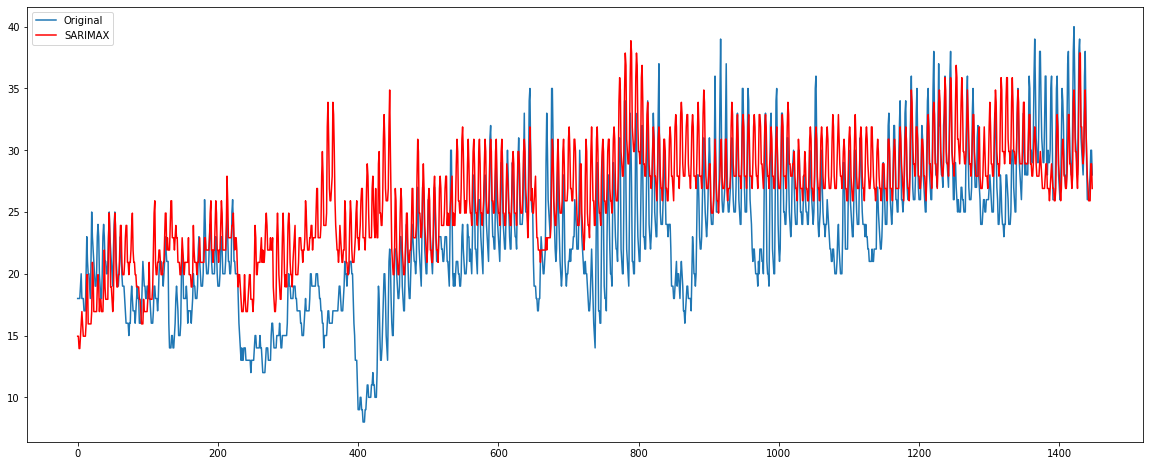

In [10]:
plt.figure(figsize = (20,8))
plt.plot(df_test.Temperature.values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()

In [11]:
# building the model
autoModel = pm.auto_arima(df_training.Temperature, trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=6, stepwise=True)
autoModel.fit(df_training.Temperature)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=50.33 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=65982.519, Time=0.40 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=62837.173, Time=2.93 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=62000.335, Time=3.73 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=65980.519, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=62319.867, Time=1.46 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=61820.392, Time=10.96 sec
 ARIMA(0,1,1)(1,0,0)[6] intercept   : AIC=62166.331, Time=2.92 sec
 ARIMA(0,1,1)(2,0,1)[6] intercept   : AIC=60940.568, Time=11.60 sec
 ARIMA(0,1,1)(2,0,0)[6] intercept   : AIC=61160.423, Time=7.36 sec
 ARIMA(0,1,1)(2,0,2)[6] intercept   : AIC=inf, Time=52.59 sec
 ARIMA(0,1,1)(1,0,2)[6] intercept   : AIC=61604.561, Time=12.37 sec
 ARIMA(0,1,0)(2,0,1)[6] intercept   : AIC=61610.557, Time=8.68 sec
 ARIMA(1,1,1)(2,0,1)[6] intercept   : AIC=60929.355, Time=15.10 sec
 ARIMA(1,1,1)(1,0,1)[6] i

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 0, 1, 6),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [ ]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = df[:len(df_training)+t]
    model = SARIMAX(temp_train.Temperature, order=order,
                    seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
# resultsDict['AutoSARIMAX {0},{1}'.format(order, seasonalOrder)] = evaluate(
#     df_test.pollution_today, yhat.values)
# predictionsDict['AutoSARIMAX {0},{1}'.format(